In [1]:
# Statistics modules
import scipy.stats as st

# Datetime class
from datetime import date
from datetime import datetime

import pandas as pd # dataframe manipulation
import numpy as np # linear algebra
from pandas.api.types import is_string_dtype, is_numeric_dtype

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

sns.set_theme()   
sns.set(color_codes=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
crime_data = pd.read_csv('crime_data.csv')

## Data Transformation and Preparation

In [3]:
# Due to the enormous size of the dataset, it was difficult for some of the code blocks to run without raising MemoryError. I filtered the dataset to only select documented
# crime information from the beginning of this year. This reduced the dataset rows from 595255 to 48261 rows.

crime_data['Assault date'] = pd.to_datetime(crime_data['Assault date'])
crime_data = crime_data[crime_data['Assault date'].dt.strftime('%Y') == '2023']

In [6]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116414 entries, 472851 to 589264
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Div_Records_No        116414 non-null  int64         
 1   Date reported         116414 non-null  object        
 2   Assault date          116414 non-null  datetime64[ns]
 3   Assault time          116414 non-null  object        
 4   Geographic area       116414 non-null  int64         
 5   Area name             116414 non-null  object        
 6   Crime description     116414 non-null  object        
 7   Victim's age          116414 non-null  int64         
 8   Victim's sex          116414 non-null  object        
 9   Victim's race         116414 non-null  object        
 10  Crime location        116414 non-null  object        
 11  Assault weapon        116414 non-null  object        
 12  Investigation status  116414 non-null  object        

In [7]:
# I was preparing the dataset to be inputted into the model, by dropping columns that are not beneficial to the purpose of the model.

crime_data = crime_data.drop(columns=['Div_Records_No', 'Date reported', 'Assault date', 'Assault time', 'Geographic area',
                                      'Crime location', 'Assault weapon', 'Investigation status', 'Address', 'Latitude', 'Longitude', 
                                      'Years since assault', 'Day of crime'])

In [8]:
# Analyzing the various types of crime and their counts.

# types_of_crimes = crime_data['Crime description'].value_counts()
# types_of_crimes.head()

In [9]:
# Filtering the crime_data DataFrame for only specific crimes that will be our focus. The dataset is too large and my laptop raised a MemoryError during one of 
# the extensive computations. I selected only the top five crimes for investigation. Including the top 10 crimes didn't improve the model, so I stuck with top 5.

crimes_in_focus = ['BATTERY - SIMPLE ASSAULT', 'THEFT OF IDENTITY', 'BURGLARY FROM VEHICLE', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
                    'INTIMATE PARTNER - SIMPLE ASSAULT'
                    # , 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 
                    # 'THEFT PLAIN - PETTY ($950 & UNDER)', 'BURGLARY', 'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
                    # 'ROBBERY', 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'CRIMINAL THREATS - NO WEAPON DISPLAYED'
                    ]

crime_data_subset = crime_data['Crime description'].isin(crimes_in_focus)
model_data = crime_data[crime_data_subset]

# Data for model is almost ready
model_data.head()

,Area name,Crime description,Victim's age,Victim's sex,Victim's race,Crime code 1
472852,N Hollywood,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",36,F,W,230
472856,Rampart,INTIMATE PARTNER - SIMPLE ASSAULT,30,F,H,626
472858,Southeast,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",42,F,H,230
472859,77th Street,THEFT OF IDENTITY,41,F,H,354
472862,Olympic,INTIMATE PARTNER - SIMPLE ASSAULT,59,F,H,626


In [10]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47960 entries, 472852 to 589262
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Area name          47960 non-null  object
 1   Crime description  47960 non-null  object
 2   Victim's age       47960 non-null  int64 
 3   Victim's sex       47960 non-null  object
 4   Victim's race      47960 non-null  object
 5   Crime code 1       47960 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.6+ MB


In [11]:
model_data.nunique()

Area name            21
Crime description     5
Victim's age         81
Victim's sex          2
Victim's race        18
Crime code 1          6
dtype: int64

In [12]:
model_data.shape

(47960, 6)

In [13]:
numeric_list = []
categorical_list = []

for column in model_data:
    if is_numeric_dtype(model_data[column]):
        numeric_list.append(column)
    elif is_string_dtype(model_data[column]):
        categorical_list.append(column)

In [14]:
numeric_list

# categorical_list

["Victim's age", 'Crime code 1']

In [15]:
# # Histogram distribution of numerical columns
# # Bar plots of categorical columns

# num_columns = sum(is_numeric_dtype(model_data[column]) for column in model_data)
# str_columns = sum(is_string_dtype(model_data[column]) for column in model_data)

# fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# for i, column in enumerate(model_data.columns):
#     ax = axes[i]
#     if is_numeric_dtype(model_data[column]):
#         model_data[column].plot(kind='hist', ax=ax)
#     elif is_string_dtype(model_data[column]):
#         model_data[column].value_counts()[:10].plot(kind='bar', ax=ax)
#         ax.set_title(column)

# # Adjust layout for better spacing between subplots
# plt.tight_layout()

In [16]:
# # For a multivariate analysis of the categorical variables

# for i in range(0, len(categorical_list)):
#     primary_category = categorical_list[i]
#     for j in range(0, len(categorical_list)):
#         secondary_category = categorical_list[j]
#         if secondary_category != primary_category:
#             plt.figure(figsize=(15, 15))
#             chart = sns.countplot(
#                 data=model_data,
#                 x=primary_category,
#                 hue=secondary_category,
#                 palette='GnBu',
#                 order=model_data[primary_category].value_counts().iloc[:10].index
#             )

In [17]:
# # Box plot of how categorical variables vary from numerical variables
# # Types of hue: YlGnBu YlOrBr YlOrRd PuBuGn vlag PRGn RdBu RdYlBu

# for i in range(0, len(categorical_list)):
#     category = categorical_list[i]
#     for j in range(0, len(numeric_list)):
#         numeric = numeric_list[j]
#         plt.figure(figsize=(15, 15))
#         sns.boxplot(x=category, y=numeric, data=model_data, palette='YlGnBu')

<Axes: xlabel="Victim's age", ylabel="Victim's sex">

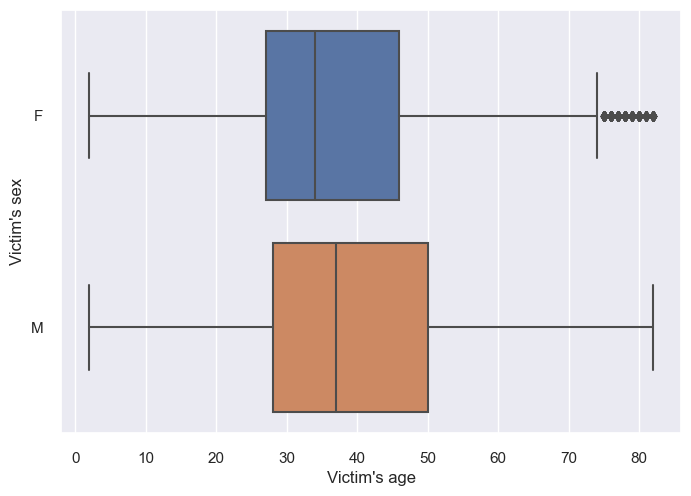

In [18]:
# Box plot variation of age with other categorical variables

# sns.boxplot(data=model_data, x='Victim\'s age', y='Victim\'s race')
sns.boxplot(data=model_data, x='Victim\'s age', y='Victim\'s sex'#, hue='Victim\'s race'
            )
# sns.boxplot(x=model_data['Victim\'s age'])

In [19]:
upper_limit = model_data['Victim\'s age'].quantile(0.90)
# lower_limit = model_data['Victim\'s age'].quantile(0.05)
model_data = model_data[model_data['Victim\'s age'] < upper_limit]
# model_data = model_data[(model_data['Victim\'s age'] > lower_limit) & (model_data['Victim\'s age'] < upper_limit)]
model_data.shape

(43117, 6)

<Axes: xlabel="Victim's age", ylabel="Victim's sex">

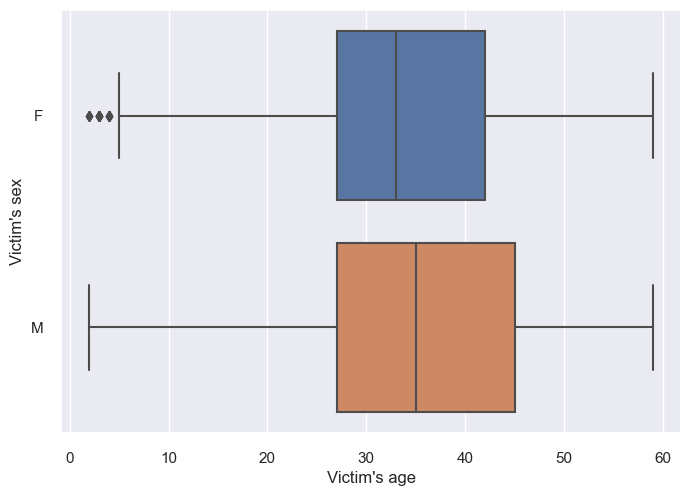

In [20]:
sns.boxplot(data=model_data, x='Victim\'s age', y='Victim\'s sex')

In [21]:
# model_data[model_data['Victim\'s age'] < 5]

In [22]:
model_data['Crime code 1'].value_counts()

624    11406
354     8268
330     8060
230     7907
626     7471
434        5
Name: Crime code 1, dtype: int64

In [23]:
# Checking for null values and dropping them (since they are quite small compared to the entire population of the dataset).


# model_data.isna().sum()
model_data = model_data.dropna()
# model_data['Day of crime'] = model_data['Day of crime'].str.lower()

In [24]:
model_data.describe(include='all')

,Area name,Crime description,Victim's age,Victim's sex,Victim's race,Crime code 1
count,43117,43117,43117.000000,43117,43117,43117.000000
unique,21,5,NaN,2,18,NaN
top,Central,BATTERY - SIMPLE ASSAULT,NaN,F,H,NaN
freq,4036,11407,NaN,22190,20578,NaN
mean,NaN,NaN,35.304868,NaN,NaN,445.338080
std,NaN,NaN,11.118557,NaN,NaN,163.371354
min,NaN,NaN,2.000000,NaN,NaN,230.000000
25%,NaN,NaN,27.000000,NaN,NaN,330.000000
50%,NaN,NaN,34.000000,NaN,NaN,354.000000
75%,NaN,NaN,43.000000,NaN,NaN,624.000000


In [25]:
# Changing the names of the columns because spaces and some characters breaks the clustering model (at some point)

new_names = {
    'BATTERY - SIMPLE ASSAULT': 'battery_simple_assault',
    'THEFT OF IDENTITY': 'identity_theft',
    'INTIMATE PARTNER - SIMPLE ASSAULT': 'gender_violence',
    'BURGLARY FROM VEHICLE': 'vehicular_break_and_entering',
    'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': 'aggravated_assault_deadly_weapon'
    # 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'vandalism_felony',
    # 'THEFT PLAIN - PETTY ($950 & UNDER)': 'petty_theft',
    # 'ROBBERY': 'robbery',
    # 'BURGLARY': 'breaking_and_entering',
    # 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)': 'vandalism_misdeameanor',
    # 'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'criminal_threats'
}

# Using the mapping dictionary to replace names in the 'Crime description' column
model_data['Crime description'] = model_data['Crime description'].map(new_names)

In [26]:
# Changing names in the column to avoid possible errors

new_names_2 = {
    'Central': 'central',
    '77th Street': '77th_street',
    'Southeast': 'southeast',
    'Newton': 'newton',
    'Southwest': 'southwest',
    'Rampart': 'rampart',
    'Olympic': 'olympic',
    'Hollywood': 'hollywood',
    'N Hollywood': 'n_hollywood',
    'Mission': 'mission',
    'Pacific': 'pacific',
    'Wilshire': 'wilshire',
    'West Valley': 'west_valley',
    'Newton': 'newton',
    'Van Nuys': 'van_nuys',
    'Topanga': 'topanga',
    'Devonshire': 'devonshire',
    'Harbor': 'harbor',
    'Northeast': 'northeast',
    'Hollenbeck': 'hollenbeck',
    'Foothill': 'foothill',
    'West LA': 'west_la'
}

# Using the mapping dictionary to replace names in the 'Area name' column
model_data['Area name'] = model_data['Area name'].map(new_names_2)

In [27]:
model_data.shape

(43117, 6)

In [24]:
# Model data is prepared for sentence embedding transformation

model_data.to_csv('model_data.csv')

## Model Building

### The LLM + Kmeans model is used for crime segmentation (classification by clustering)

In [25]:
# I don't really have an explanation for doing this. The code was initially giving me a bunch of errors, so I tried to follow exactly how it was done.

# model_data = model_data.iloc[:, :]

In [26]:
# Since our problem is a classification problem with more than one categorical variable, the method of transforming the text into numerical vectors is the 
# Sentence Embedding (LLM). Providing input to the information-rich Kmeans model, will return better predictions.
# The code is in a different python script.

embedded_model_data = pd.read_csv('embedded_model_data.csv')

In [27]:
# Functions to be called for plotting the Principal Component Analysis (PCA) 2D and 3D plots. Not essential to understand or comprehend.
# They must be defined for the model to work.
    
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()

In [28]:
# This is the Python Outlier Detection (PyOD) library for detecting outliers for different cases. 
# The ECOD method (“empirical cumulative distribution functions for outlier detection”) is the specific method used.

clf = ECOD()
clf.fit(embedded_model_data)


out = clf.predict(embedded_model_data) 
embedded_model_data["outliers"] = out
model_data["outliers"] = out

embedded_model_data_no_out = embedded_model_data[embedded_model_data["outliers"] == 0]
embedded_model_data_no_out = embedded_model_data_no_out.drop(["outliers"], axis = 1)


embedded_model_data_with_out = embedded_model_data.copy()
embedded_model_data_with_out = embedded_model_data_with_out.drop(["outliers"], axis = 1)

In [29]:
embedded_model_data_no_out.shape

(38807, 384)

In [30]:
embedded_model_data_with_out.shape

(43119, 384)

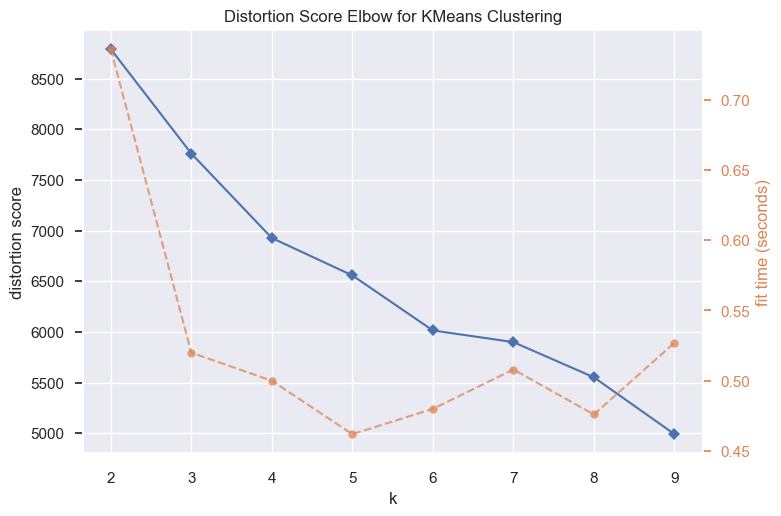

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# Instantiating the clustering model and visualizer

km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=False)
 
visualizer.fit(embedded_model_data_no_out)        # Fitting the data to the visualizer
visualizer.show()

In [36]:
# Fitting the features and target to the Kmeans model

n_clusters = 5

clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(embedded_model_data_no_out)
print(clusters.inertia_)
clusters_predict = clusters.predict(embedded_model_data_no_out)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


6345.101009635058


In [37]:
# Vital statistical measures that validates performance of the model fit.

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of 
within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(embedded_model_data_no_out, clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(embedded_model_data_no_out, clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an 
optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(embedded_model_data_no_out, clusters_predict)}")

Davies bouldin score: 1.8210441512290287
Calinski Score: 5899.754969028001
Silhouette Score: 0.2296966940078483


In [38]:
# This code takes into account the variability contained in the first 3 components of the PCA analysis.
# A value close to 80% is usually ideal.

pca_3d_object, df_pca_3d = get_pca_3d(embedded_model_data_no_out, clusters_predict)
# plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1) # 3D plot of PCA
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0             54.289        14.14%                     14.14%
1             41.754        10.87%                     25.01%
2             39.482        10.28%                     35.29%


In [33]:
# pca_2d_object, df_pca_2d = get_pca_2d(embedded_model_data_with_out, clusters_predict)
# plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)

In [45]:
sampling_data = embedded_model_data_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values


# 2D Plot of the T-distributed stochastic neighbor embedding (t-SNE) for visualizing the similarities between different data points.

df_tsne_2d = TSNE(
                  n_components=2, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "T-SNE Space", opacity=0.5, width_line = 0.5)

In [47]:
# 3D plot of t-SNE

df_tsne_3d = TSNE(
                  n_components=3, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)

In [38]:
model_data_no_outliers = model_data[model_data["outliers"] == 0]
model_data_no_outliers = model_data_no_outliers.drop("outliers", axis = 1)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 38808, number of used features: 6
[LightGBM] [Info] Start training from score -1.464964
[LightGBM] [Info] Start training from score -1.184949
[LightGBM] [Info] Start training from score -1.524697
[LightGBM] [Info] Start training from score -1.979849
[LightGBM] [Info] Start training from score -2.231430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

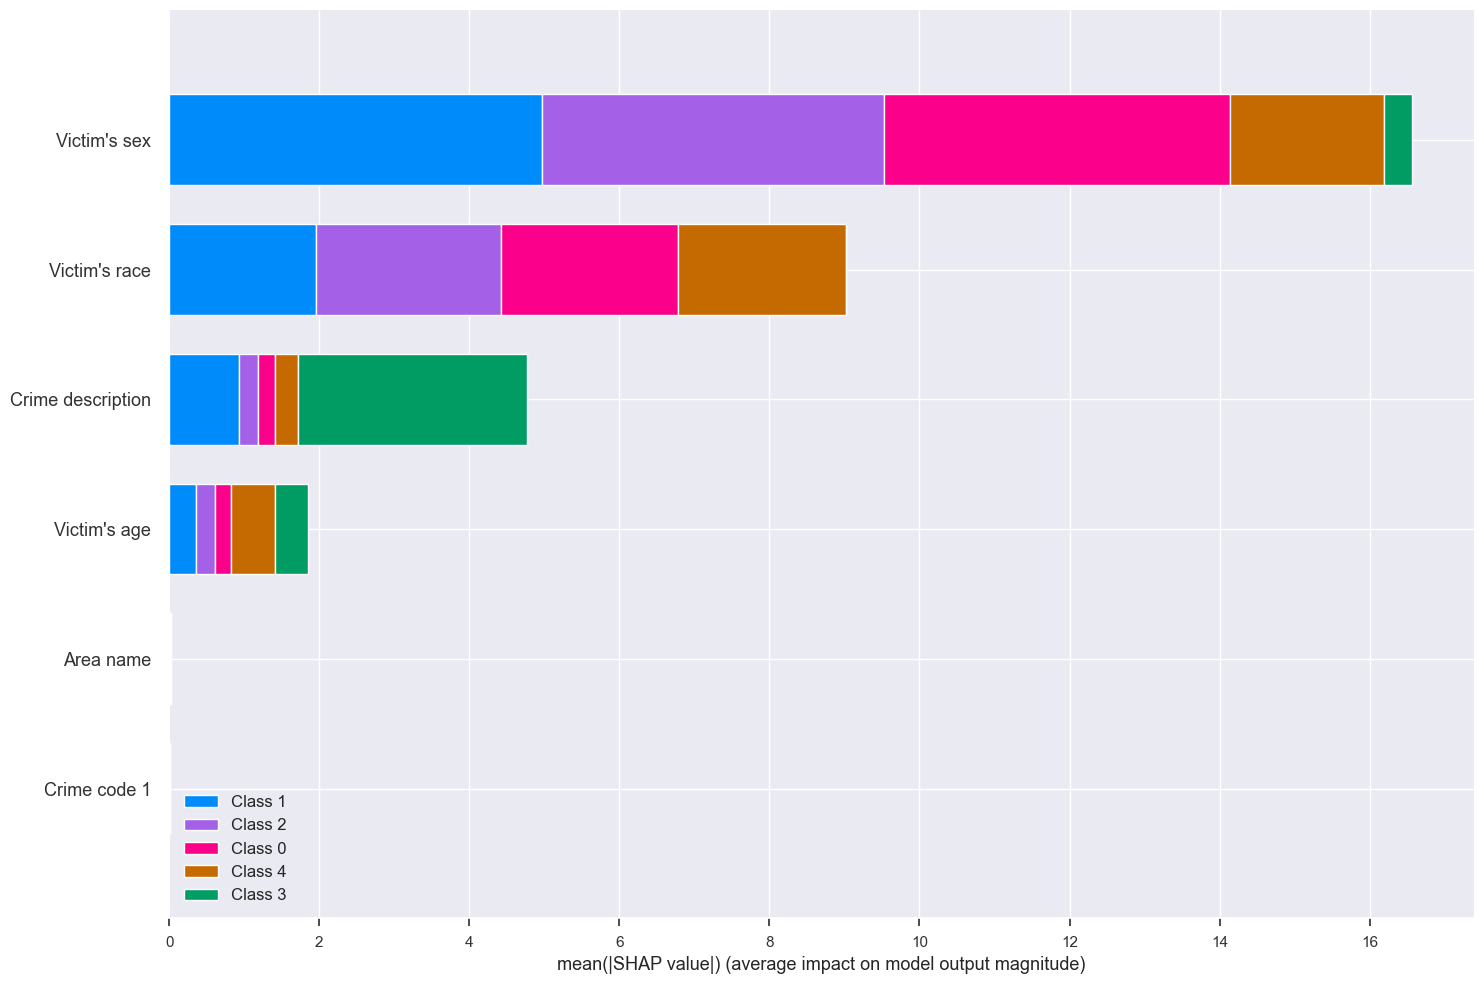

In [39]:
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["Area name", "Crime description", "Victim's sex", "Victim's race", "Crime code 1"]:
    model_data_no_outliers[col] = model_data_no_outliers[col].astype('category')

clf_km.fit(X=model_data_no_outliers, y=clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(model_data_no_outliers)
shap.summary_plot(shap_values_km, model_data_no_outliers, plot_type="bar", plot_size=(15, 10))

In [ ]:
y_pred = clf_km.predict(model_data_no_outliers)
accuracy = accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

In [51]:
# Segementation of crimes by crime description, area name, victim's age, sex, descent and crime severity.

model_data_no_outliers["cluster"] = clusters_predict

model_data_group = model_data_no_outliers.groupby('cluster').agg(
    {
        "Crime description": lambda x: x.value_counts().index[0],
        "Area name": lambda x: x.value_counts().index[0],
        "Victim's age": 'mean',
        "Victim's sex": lambda x: x.value_counts().index[0],
        "Victim's race": lambda x: x.value_counts().index[0],
        "Crime code 1": lambda x: x.value_counts().index[0],
        
    }
).sort_values("Crime description").reset_index()
model_data_group

,cluster,Crime description,Area name,Victim's age,Victim's sex,Victim's race,Crime code 1
0,1,battery_simple_assault,central,35.096900,M,H,624.0
1,2,gender_violence,77th_street,34.356371,F,B,626.0
2,3,gender_violence,central,35.055537,F,H,626.0
3,0,identity_theft,southeast,36.058220,F,H,354.0
4,4,vehicular_break_and_entering,central,37.106534,M,W,330.0
